<a href="https://colab.research.google.com/github/artakhm/HomeCredit/blob/master/home_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
sns.set(style="darkgrid")
!pip install imbalanced-learn
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score,recall_score,roc_auc_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, cross_validate,train_test_split
from google.colab import drive  
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Mounted at /content/drive


Загрузим уже подготовленные в предыдущем ноутбуке данные.

In [ ]:
train = pd.read_csv('/content/drive/My Drive/HomeCredit/X.csv')

In [ ]:
bad_indices = np.where(np.isinf(train))
train = train.drop(bad_indices[0])

In [ ]:
X=train.drop(columns=['TARGET'])
y=train['TARGET']

## Feature Importances

Посчитаем корреляцию Пирсона с таргетом для каждого признака

In [ ]:
X['TARGET'] = y
correlations = X.corr()['TARGET'].sort_values()
X.drop(columns=['TARGET'], inplace=True)
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 bureau_DAYS_CREDIT_max                    0.052740
CODE_GENDER_M                             0.054721
DAYS_LAST_PHONE_CHANGE                    0.055216
NAME_INCOME_TYPE_Working                  0.057473
PREV_NAME_PRODUCT_TYPE_walk-in_MEAN       0.057803
REGION_RATING_CLIENT_W_CITY               0.060894
DAYS_EMPLOYED                             0.063359
bureau_DAYS_ENDDATE_FACT_mean             0.067165
CREDIT_TO_GOODS_PERCENT                   0.068469
bureau_DAYS_CREDIT_UPDATE_mean            0.069697
bureau_DAYS_CREDIT_min                    0.072886
PREV_NAME_CONTRACT_STATUS_Refused_MEAN    0.077889
DAYS_BIRTH                                0.078239
bureau_DAYS_CREDIT_mean                   0.083975
TARGET                                    1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 SOURCES_WEIGHTED                          -0.213818
SOURCES_MULT                              -0.189614
EXT_SOURCE_2                              -

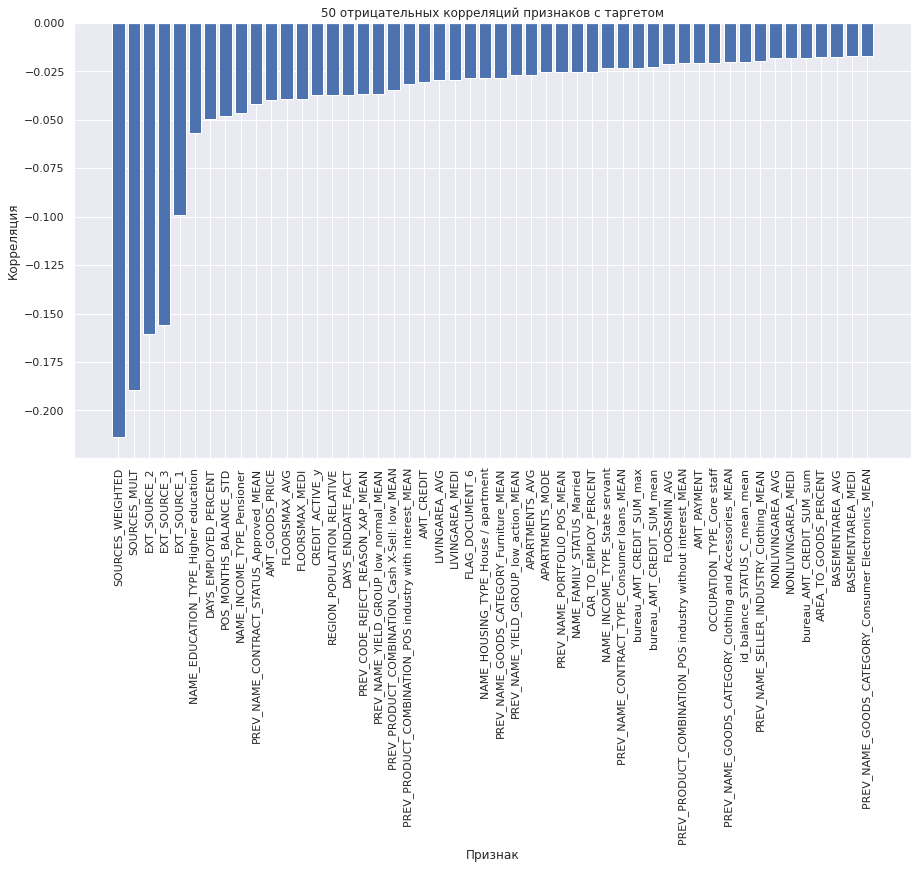

In [ ]:
plt.figure(figsize=(15, 8))
plt.xlabel('Признак')
plt.ylabel('Корреляция')
plt.title('50 отрицательных корреляций признаков с таргетом')
plt.bar(correlations.index[:50], correlations[:50])
plt.xticks(rotation=90)
plt.savefig('corr2')
plt.show()

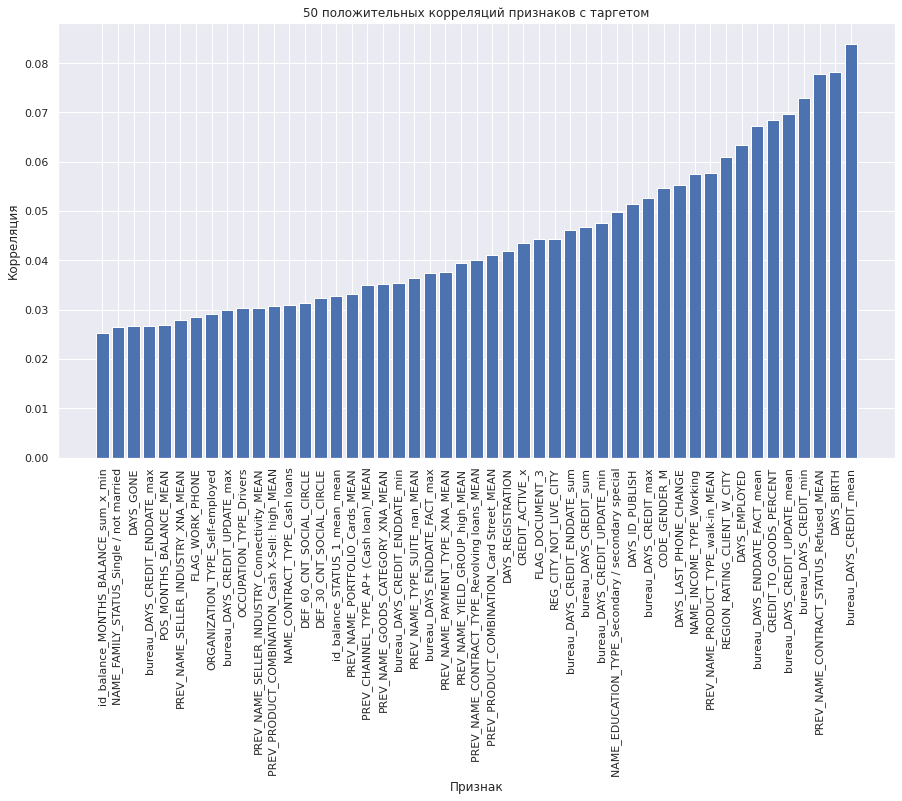

In [ ]:
plt.figure(figsize=(15, 8))
plt.xlabel('Признак')
plt.ylabel('Корреляция')
plt.title('50 положительных корреляций признаков с таргетом')
plt.bar(correlations.index[-50:-1], correlations[-50:-1])
plt.xticks(rotation=90)
plt.savefig('corr1')
plt.show()

Воспользуемся градиентным бустингом для подсчета важноти признаков

In [ ]:
gb_clf = XGBClassifier(n_estimators=1000, objective= 'binary:logistic', eval_metric='auc', scale_pos_weight=11).fit(X, y)

In [ ]:
feat_imp = pd.Series(gb_clf.feature_importances_,X.columns).sort_values(ascending=False)

In [ ]:
# feat_imp = pd.read_csv('/content/drive/My Drive/HomeCredit/feat_imps.csv')

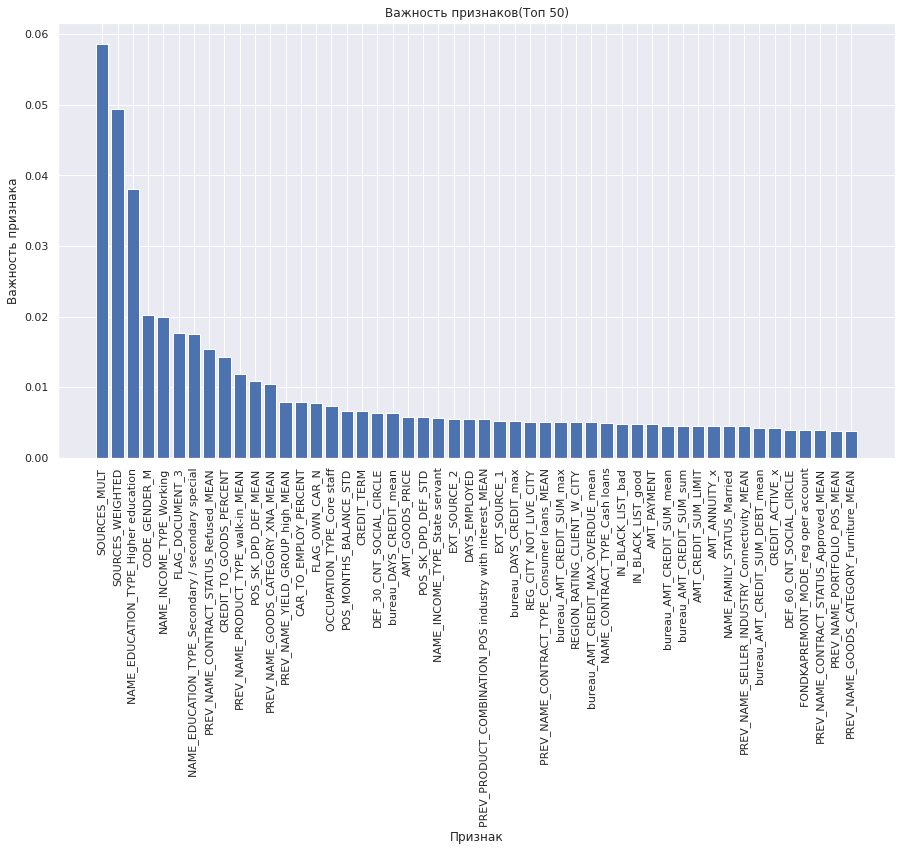

In [ ]:
plt.figure(figsize=(15, 8))
plt.xlabel('Признак')
plt.ylabel('Важность признака')
plt.title('Важность признаков(Топ 50)')
plt.bar(feat_imp.index[:50],feat_imp[:50])
plt.xticks(rotation=90)
# plt.savefig('feature_importances_100')
plt.show()


На хитмапе корреляций Пирсона много признаков не видно будет, поэтому только 15 признаков.

In [ ]:
X_corr=X[feat_imp.index[:15].to_list()]
X_corr['TARGET']=y
corrMatrix = X_corr.corr()

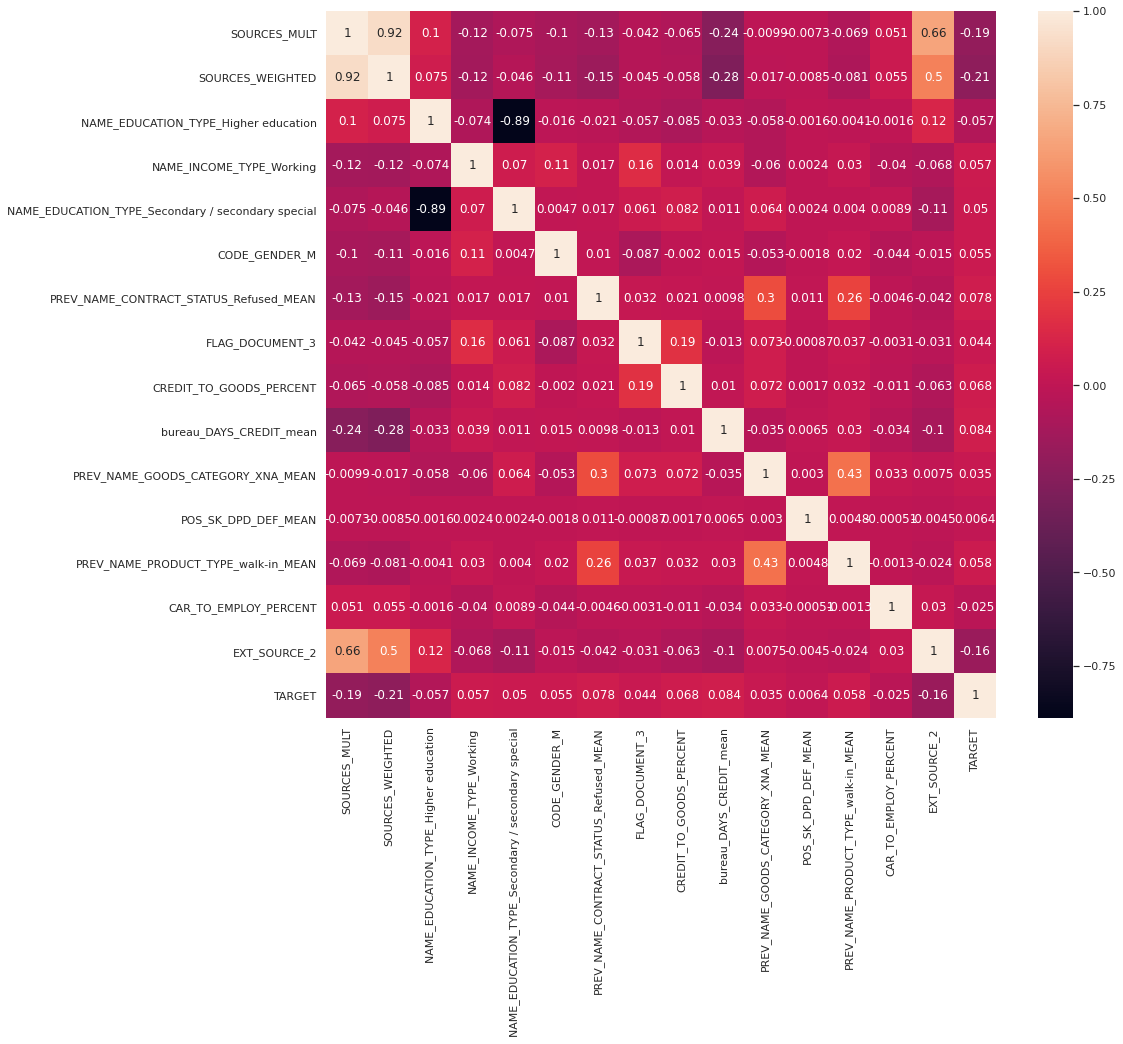

In [ ]:
plt.figure(figsize=(15, 13))
sns.heatmap(corrMatrix, annot=True)
plt.show()

## Undersampling and Normalize

Возьмем только 200 лучших признаков, остальные не дадут нам значительного прироста в качестве, у замедлят работу.

In [ ]:
X = X[feat_imp.index[:200]]

Отнормируем данные 

In [ ]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [ ]:
X['TARGET'] = y
X.to_csv('/content/drive/My Drive/HomeCredit/X.csv', index=False)

Отбалансированная версия выборки

In [ ]:
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_und, y_und = undersample.fit_resample(X, y)

In [ ]:
X_und.shape

(74472, 200)

In [ ]:
model = LinearSVC().fit(X_und,y_und)

## Модель

### Logreg

In [ ]:
params = {
    'penalty': ['l1','l2'],
    'tol': [1e-3,1e-4,1e-5],
    'C':[0.25, 0.5, 1,1.25, 1.5],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
    'max_iter': [500, 1000, 1500, 2000]
}

model = LogisticRegression()

grid = RandomizedSearchCV(model, params, scoring=[
    'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, refit='roc_auc', n_jobs=1, n_iter=40, verbose=0, random_state=42)

grid.fit(X_und, y_und)
print(f'{grid.best_estimator_}, {grid.best_score_}')

LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 0.7585255177642688


In [ ]:
model = grid.best_estimator_
scores = cross_validate(model, X_und, y_und, scoring=[
                        'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, return_train_score=True, n_jobs=1)

i_accuracy = np.mean(scores['test_accuracy'])
i_roc_auc = np.mean(scores['test_roc_auc'])
i_precision = np.mean(scores['test_precision'])
i_recall = np.mean(scores['test_recall'])

print('accuracy: %.3f | roc_auc: %.3f | precision: %.3f | recall: %.3f' % (i_accuracy, i_roc_auc, i_precision, i_recall))

accuracy: 0.729 | roc_auc: 0.759 | precision: 0.641 | recall: 0.428


### SVM

#### SVC

In [ ]:
params = {
    'tol': [1e-2, 1e-3,1e-4],
    'C':[0.5, 1, 1.5],
    'kernel': ['linear', 'poly', 'rbf'],
    'max_iter': [1500]
}

model = SVC()

grid = RandomizedSearchCV(model, params, scoring=[
    'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, refit='roc_auc', n_jobs=1, n_iter=40, verbose=0, random_state=42)

grid.fit(X_und, y_und)
print(f'{grid.best_estimator_}, {grid.best_score_}')

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=1500, probability=False, random_state=None, shrinking=True,
    tol=0.01, verbose=False), 0.5918451777130816


In [ ]:
model = grid.best_estimator_
scores = cross_validate(model, X_und, y_und, scoring=[
                        'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, return_train_score=True, n_jobs=1)

i_accuracy = np.mean(scores['test_accuracy'])
i_roc_auc = np.mean(scores['test_roc_auc'])
i_precision = np.mean(scores['test_precision'])
i_recall = np.mean(scores['test_recall'])

print('accuracy: %.3f | roc_auc: %.3f | precision: %.3f | recall: %.3f' % (i_accuracy, i_roc_auc, i_precision, i_recall))

accuracy: 0.479 | roc_auc: 0.592 | precision: 0.365 | recall: 0.755


#### LinearSVC

In [ ]:
params = {
    'penalty': ['l1','l2'],
    'tol': [1e-2, 1e-3,1e-4],
    'C':[0.5, 1, 1.5],
    'max_iter': [1500]
}

model = LinearSVC()

grid = RandomizedSearchCV(model, params, scoring=[
    'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, refit='roc_auc', n_jobs=1, n_iter=40, verbose=0, random_state=42)

grid.fit(X_und, y_und)
print(f'{grid.best_estimator_}, {grid.best_score_}')

LinearSVC(C=1.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), 0.7584645951923891


In [ ]:
model = grid.best_estimator_
scores = cross_validate(model, X_und, y_und, scoring=[
                        'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, return_train_score=True, n_jobs=1)

i_accuracy = np.mean(scores['test_accuracy'])
i_roc_auc = np.mean(scores['test_roc_auc'])
i_precision = np.mean(scores['test_precision'])
i_recall = np.mean(scores['test_recall'])

print('accuracy: %.3f | roc_auc: %.3f | precision: %.3f | recall: %.3f' % (i_accuracy, i_roc_auc, i_precision, i_recall))

accuracy: 0.728 | roc_auc: 0.758 | precision: 0.646 | recall: 0.408


In [ ]:
model

LinearSVC(C=1.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### Random Forest

In [ ]:
params = {
    'n_estimators': [5000],
    'criterion':['gini', 'entropy']
}

model = RandomForestClassifier()

grid = RandomizedSearchCV(model, params, scoring=[
    'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, refit='roc_auc', n_jobs=1, n_iter=80, verbose=0, random_state=42)

grid.fit(X_und, y_und)
print(f'{grid.best_estimator_}, {grid.best_score_}')

In [ ]:
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
scores = cross_validate(model, X_und, y_und, scoring=[
                        'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, return_train_score=True, n_jobs=1)

i_accuracy = np.mean(scores['test_accuracy'])
i_roc_auc = np.mean(scores['test_roc_auc'])
i_precision = np.mean(scores['test_precision'])
i_recall = np.mean(scores['test_recall'])

print('accuracy: %.3f | roc_auc: %.3f | precision: %.3f | recall: %.3f' % (i_accuracy, i_roc_auc, i_precision, i_recall))

accuracy: 0.725 | roc_auc: 0.760 | precision: 0.696 | recall: 0.311


### GB

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
balance = train[train.TARGET ==0].TARGET.count() / train[train.TARGET ==1 ].TARGET.count()

#### LightGBM

In [ ]:
params = {
    'reg_alpha': [0, 0.25, 0.5],
    'reg_lambda': [0, 0.25, 0.5],
    'n_estimators': [500, 750, 1000, 1250],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [i for i in range(2, 6)],
    'min_data_in_leaf': [20, 50, 100]
}

model = LGBMClassifier(boosting_type='gbdt', random_state=42, n_jobs=-1,
                       subsample=0.4, neg_bagging_fraction=0.1, verbose=-1)

grid = RandomizedSearchCV(model, params, scoring=[
    'accuracy', 'roc_auc'], cv=3, refit='roc_auc', n_jobs=1, n_iter=80, verbose=0, random_state=42)

grid.fit(X_train, y_train)
print(f'{grid.best_estimator_}, {grid.best_score_}')

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=2,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=100, min_split_gain=0.0, n_estimators=1250,
               n_jobs=-1, neg_bagging_fraction=0.1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0, reg_lambda=0.25,
               silent=True, subsample=0.4, subsample_for_bin=200000,
               subsample_freq=0, verbose=-1), 0.7763610599661934


In [ ]:
model = LGBMClassifier(boosting_type='gbdt',learning_rate=0.1, max_depth=2, min_data_in_leaf=100, n_estimators=1250, reg_alpha=0,reg_lambda=0.25 , random_state=42, n_jobs=-1, neg_bagging_fraction=0.1, verbose=-1).fit(X_train, y_train)

print('accuracy_score:', accuracy_score(y_test, model.predict(X_test)))
print('precision_score:', precision_score(y_test, model.predict(X_test)))
print('recall_score:', recall_score(y_test, model.predict(X_test)))
print('roc_auc_score:',roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

accuracy_score: 0.9206542770271369
precision_score: 0.5934959349593496
recall_score: 0.0442513639119014
roc_auc_score: 0.7819820306247393


#### XGBClassifier

In [ ]:
params = {
    'reg_alpha': [0, 0.25, 0.5],
    'reg_lambda': [0, 0.25, 0.5],
    'n_estimators': [1000, 1500, 2000,2500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [i for i in range(2, 6)],
    'min_data_in_leaf': [20, 50, 100]
}

model = XGBClassifier(tree_method='gpu_hist', objective= 'binary:logistic', 
                      eval_metric='auc', scale_pos_weight=balance, subsample=0.4)

grid = RandomizedSearchCV(model, params, scoring=[
    'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, refit='roc_auc', n_jobs=1, n_iter=80, verbose=0, random_state=42)

grid.fit(X_train, y_train)
print(f'{grid.best_estimator_}, {grid.best_score_}')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, min_data_in_leaf=100, missing=None,
              n_estimators=2000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0.25,
              reg_lambda=0, scale_pos_weight=11.387150050352467, seed=None,
              silent=None, subsample=0.4, tree_method='gpu_hist', verbosity=1), 0.7731921697243959


In [ ]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, min_data_in_leaf=100, n_estimators=2000, n_jobs=-1,
              objective='binary:logistic', random_state=0, reg_alpha=0.25,
              reg_lambda=0, scale_pos_weight=11.387150050352467, tree_method='gpu_hist', verbosity=1)

scores = cross_validate(model, X_train, y_train, scoring=[
                        'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, return_train_score=True, n_jobs=1)

i_accuracy = np.mean(scores['test_accuracy'])
i_roc_auc = np.mean(scores['test_roc_auc'])
i_precision = np.mean(scores['test_precision'])
i_recall = np.mean(scores['test_recall'])

print('accuracy: %.3f | roc_auc: %.3f | precision: %.3f | recall: %.3f' % (i_accuracy, i_roc_auc, i_precision, i_recall))

accuracy: 0.726 | roc_auc: 0.772 | precision: 0.180 | recall: 0.673


### Kmeans 

Воспользуемся методом elbow, для нахождения подходящего числа кластеров.

In [ ]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    print(k,'done')

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(range(1,15), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Поиск оптимального k с помощью метода Elbow')
plt.savefig('elbow.png')
plt.show()

6 - ниболее подходящее, исходя из графика, решение. Добавим и закодируем новый признакв с помощью One Hot.

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
X['CLUSTER'] = kmeans.labels_
X.CLUSTER=X.CLUSTER.astype('object')
X = pd.get_dummies(X, prefix='CLUSTER')

Построим модель с новым признаком.

In [ ]:
model = XGBClassifier(base_score=0.5, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, learning_rate=0.01,
              max_depth=5, min_child_weight=1, min_data_in_leaf=100, n_estimators=2500,
              n_jobs=-1, num_parallel_tree=1, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=0.5,
              scale_pos_weight=11.387)

scores = cross_validate(model, X, y, scoring=[
                        'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, return_train_score=True, n_jobs=-1)

i_accuracy = np.mean(scores['test_accuracy'])
i_roc_auc = np.mean(scores['test_roc_auc'])
i_precision = np.mean(scores['test_precision'])
i_recall = np.mean(scores['test_recall'])

print('accuracy: %.3f | roc_auc: %.3f | precision: %.3f | recall: %.3f' % (i_accuracy, i_roc_auc, i_precision, i_recall))

###  Blending

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, learning_rate=0.01,
              max_depth=5, min_child_weight=1, min_data_in_leaf=100, n_estimators=2500,
              n_jobs=-1, num_parallel_tree=1, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=0.5,
              scale_pos_weight=11.387, subsample=0.4).fit(X_train, y_train)

xgb_pred=xgb.predict(X_test)

In [ ]:
rf = RandomForestClassifier(n_estimators=2000, n_jobs=-1, class_weight= 'balanced').fit(X_train, y_train)

rf_pred=rf.predict(X_test)

In [ ]:
svc = SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=1500, probability=False, random_state=None, shrinking=True,
    tol=0.01, verbose=False).fit(X_train,y_train)

svc_pred = svc.predict(X_test)

In [ ]:
logreg = LogisticRegression(C=1.5, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False).fit(X_train, y_train)

logreg_pred = logreg.predict(X_test)

In [ ]:
lsvc = LinearSVC(C=1.5, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0).fit(X_train,y_train)

lsvc_pred = lsvc.predict(X_test)

Сольем все предсказание в один датаест и обучим мета-модель для финальной аггрегации предсказаний.

In [ ]:
X_blend = pd.DataFrame(data={'xgb':xgb_pred, 'lsvc':lsvc_pred, 'rf':rf_pred, 'svc':svc_pred, 'logreg':logreg_pred})

params = {
    'tol': [1e-3,1e-4,1e-5],
    'C':[0.5, 1,1.25, 1.5],
    'solver': ['newton-cg', 'lbfgs'],
    'max_iter': [2000],
    'class_weight':['balanced']
}

model = LogisticRegression()

grid = RandomizedSearchCV(model, params, scoring=[
    'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, refit='roc_auc', n_jobs=1, n_iter=40, verbose=0, random_state=42)

grid.fit(X_blend, y_test)
print(f'{grid.best_estimator_}, {grid.best_score_}')


model = grid.best_estimator_
scores = cross_validate(model, X_blend, y_test, scoring=[
                        'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, return_train_score=True, n_jobs=-1)

i_accuracy = np.mean(scores['test_accuracy'])
i_roc_auc = np.mean(scores['test_roc_auc'])
i_precision = np.mean(scores['test_precision'])
i_recall = np.mean(scores['test_recall'])

print('accuracy: %.3f | roc_auc: %.3f | precision: %.3f | recall: %.3f' % (i_accuracy, i_roc_auc, i_precision, i_recall))